# Introduction

Ce projet vise à explorer la reconstruction d’images à l’aide des Vision Transformers (ViT) en utilisant une stratégie de masquage inspirée du NLP. L’idée est de cacher une partie des patchs d’une image et d’entraîner un modèle à les reconstruire. Cette approche permet d’apprendre des représentations visuelles robustes.


**CIFAR-10 Dataset**

Le jeu de données CIFAR-10 est un ensemble d'images largement utilisé pour l'entraînement des modèles de machine learning. Il se compose de 60 000 images en couleur, réparties en 10 classes différentes, avec chaque image ayant une taille de 32x32 pixels et 3 canaux de couleur (RGB).

50 000 images d'entraînement : Celles-ci sont stockées dans x_train.

10 000 images de test : Celles-ci sont stockées dans x_test.

Chaque image a une dimension de 32x32 pixels avec 3 canaux (RGB).

# Pramétres généraux

In [ ]:
# Imports principaux pour le deep learning et la manipulation d'images
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Bibliothèques classiques pour le traitement des données
import numpy as np
import matplotlib.pyplot as plt

# Métriques pour l’évaluation de la reconstruction
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Paramètres globaux
AUTO = tf.data.AUTOTUNE  # Optimisation du chargement des données
BATCH_SIZE = 64          # Taille du batch
BUFFER_SIZE = 1024       # Taille du buffer de shuffle
IMAGE_SIZE = 32          # Taille des images (CIFAR-10: 32x32)
PATCH_SIZE = 4           # Taille de chaque patch (4x4)
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  # Nombre total de patchs par image
MASK_RATIO = 0.5         # Proportion de patchs masqués
PROJECTION_DIM = 64      # Dimension dans laquelle chaque patch est projeté
TRANSFORMER_LAYERS = 4   # Nombre de couches Transformer
NUM_HEADS = 4            # Nombre de têtes dans l’attention multi-tête
MLP_UNITS = [128, 64]    # Architecture du feed-forward network dans le Transformer
EPOCHS = 40              # Nombre d’époques pour l'entraînement
NUM_MASK = int(NUM_PATCHES * MASK_RATIO)


# Téléchargement et découverte des données

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (x_train[:40000], y_train[:40000]), (x_train[40000:], y_train[40000:])

===> On a téléchargé le dataset CIFAR-10
* x_train contien les images d'entrainement (50000 au total)
* y_train cotient les labels correspondants
* x_test, y_test sont les données de test (10000 images)

Puis on a gardé 40000 images pour l'entrainement et 10000 pour la validation.

=> On obtient 3 jeux de données: train, val, test

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)
val_ds = tf.data.Dataset.from_tensor_slices(x_val).batch(BATCH_SIZE).prefetch(AUTO)
test_ds = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE).prefetch(AUTO)

===>

* from_tensor_slices(x_train) : convertit le tableau NumPy en Dataset TensorFlow.

* .shuffle(BUFFER_SIZE) : mélange les données pour éviter l’ordre fixe.

* .batch(BATCH_SIZE) : groupe les images par lot de 64.

* .prefetch(AUTO) : permet à TensorFlow de pré-charger les données pendant que le modèle s’entraîne (améliore les performances).

De méme pour val_ds et test_ds mais sans shuffle car on ne veut pas mélanger les validations/tests

In [ ]:
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [ ]:
x_train.shape

(40000, 32, 32, 3)

===> Chaque image est de taille 32*32 pixels et le nombre de canaux de couleur est 3 (Red, Green, Blue) , ils sont des images RGB.

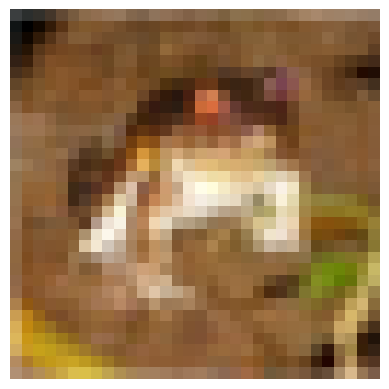

In [ ]:
plt.imshow(x_train[0])  # Affiche l'image à l'index 0
plt.axis('off')  # Désactive les axes
plt.show()

# Construction des patches

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):#constructeur
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))
        #aplatir chaque patch (le rendre un vcteur plat de taille patch_size*patch_size*3)

    def call(self, images):#decoupage de l'image en patches.
        # Convert to float32 if needed
        images = tf.cast(images, tf.float32)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )#extraire tous les petits carrés de l'image sans les superposer
        patches = self.resize(patches)#chaque patch est aplati
        return patches

    def show_patched_image(self, images, patches):#visualisation
      idx = np.random.choice(patches.shape[0])#selectionne une image au hasard
      print(f"Index selected: {idx}.")

      # Show the original image
      plt.figure(figsize=(4, 4))
      plt.imshow(keras.utils.array_to_img(images[idx]))
      plt.axis("off")
      plt.title("Original Image")
      plt.show()

      # Display individual patches / affiche tous les patches sous forme d'une grille
      n = int(np.sqrt(patches.shape[1]))
      plt.figure(figsize=(4, 4))
      for i, patch in enumerate(patches[idx]):
          ax = plt.subplot(n, n, i + 1)
          patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
          patch_img = tf.clip_by_value(patch_img, 0, 255)
          plt.imshow(patch_img.numpy().astype("uint8"))
          plt.axis("off")
      plt.suptitle("Patches")
      plt.tight_layout()
      plt.show()

      return idx



    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):#recostruction de l'image
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

===> La classe Patches est une couche personnalisée qui extrait des patchs à partir d'une image.
Elle permet ensuite de :

* Aplatir les patchs sous forme de vecteurs,

* Visualiser les patchs extraits par rapport à l'image d'origine,

* Reconstruire l'image d'origine à partir des patchs.

=> Fonction __init__
Cette fonction initialise la classe :

* Elle définit la taille des patchs

* Elle prépare une couche Reshape pour transformer les patchs extraits en vecteurs 1D.

=> Fonction call
Cette fonction est appelée lors de l'exécution de la couche :

* Elle convertit les images en float32.

* Elle utilise tf.image.extract_patches pour découper l'image en patchs de taille patch_size.

* Puis elle aplatit ces patchs pour les préparer à un traitement futur (par exemple pour un modèle de type Transformer).

=> Fonction show_patched_image
Cette fonction permet de visualiser :

* L'image d'origine choisie aléatoirement,

* Tous les patchs extraits de cette image. Cela aide à vérifier visuellement que l'extraction de patchs fonctionne correctement.

=> Fonction reconstruct_from_patch
Cette fonction permet de reconstruire une image complète à partir de ses patchs extraits :

* Elle remet les patchs dans l'ordre pour reformer l'image originale.

* C'est utile pour contrôler la qualité de la découpe et pour certaines phases de monitoring pendant l'entraînement.



Index selected: 45.


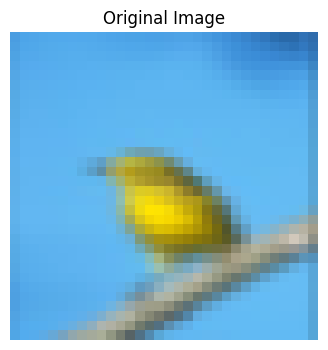

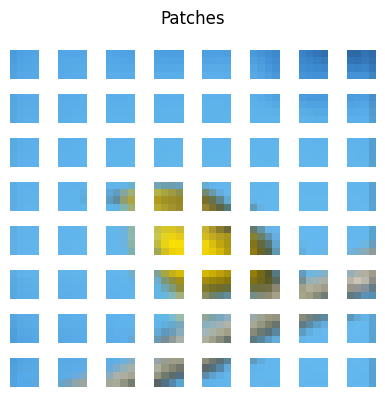

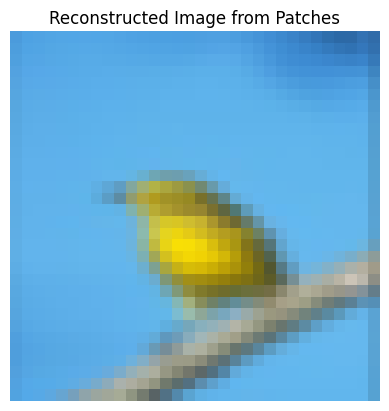

In [ ]:
# démonstration compléte de comment utiliser la classe Patches
image_batch = next(iter(train_ds))  # resultat: tenseurde forme: (BATCH_SIZE, 32, 32, 3)

# Define the patch layer
patch_layer = Patches()

# Get patches
patches = patch_layer(images=image_batch)#utilise la méthode call() de Patch_Layer pour extraire les patches de chaque image du batch

# Visualize one image and its patches
random_index = patch_layer.show_patched_image(images=image_batch, patches=patches)

# Reconstruct and show the selected image
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(tf.clip_by_value(image, 0, 255).numpy().astype("uint8"))
plt.title("Reconstructed Image from Patches")
plt.axis("off")
plt.show()


===> Ce bloc de code montre comment utiliser la classe Patches pour :

* Extraire des patchs à partir d'un batch d'images,

* Visualiser une image d'origine et ses patchs,

* Reconstruire une image à partir des patchs extraits.

# Masquage

**Stratégies de masquage**

Les stratégies de masquage sont des méthodes permettant de sélectionner quels patches seront masqués dans l'image. Ces stratégies sont essentielles pour les modèles qui tentent de reconstruire une image ou de faire des prédictions à partir de données incomplètes. Les différentes stratégies de masquage sont les suivantes :

* "random" (aléatoire) :

 Masque les patches de manière aléatoire. Le nombre de patches à masquer est déterminé par num_mask ou masking_ratio.

* "row" (ligne) :

 Masque des lignes entières de patches. Le nombre de lignes à masquer est calculé en fonction de num_mask et de la taille de la grille (par exemple, une image de 16x16 patches).

* "column" (colonne) :

 Masque des colonnes entières de patches, de manière similaire à la stratégie "row", mais au lieu de masquer les lignes, on masque les colonnes.

* "importance" (basée sur l'importance) :

 Masque les patches en fonction de leur "importance", calculée par la variance et l'énergie des patches. Les patches ayant une faible variance ou énergie sont masqués en priorité.

In [ ]:
class PatchEncoder(layers.Layer):#encoder les patches d’images, avec différentes stratégies de masquage
    def __init__(self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, num_mask=NUM_MASK, masking_strategy="random", masking_ratio=None):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim) #dimension dans laquelle chaque patch est projeté.
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        self.num_mask = num_mask #nombre de patches à masquer.
        self.masking_strategy = masking_strategy
        self.masking_ratio = masking_ratio  # Store masking_ratio

    def get_random_mask_indices(self, batch_size):
      #Utilise tf.random.uniform pour trier les patches de manière aléatoire et sélectionne les num_mask premiers comme indices à masquer.
        rand_indices = tf.argsort(tf.random.uniform((batch_size, self.num_patches)), axis=-1)
        return rand_indices

    def get_row_mask_indices(self, batch_size):
      #Divise l’image en une grille.
        grid_size = int(np.sqrt(self.num_patches))
      #Sélectionne des lignes complètes à masquer.
        row_to_mask = np.random.randint(0, grid_size)
        row_indices = tf.reshape(tf.tile(tf.range(self.num_patches), [batch_size]), (batch_size, self.num_patches))
      #S’assure que le reste est non masqué.
        row_mask = row_indices // grid_size == row_to_mask
      #Utilise tf.random.uniform pour trier les patches de manière aléatoire et sélectionne les num_mask premiers comme indices à masquer.
        rand = tf.argsort(tf.random.uniform((batch_size, self.num_patches)), axis=-1)
      #mettre les indices à masquer en premier.
        final_order = tf.argsort(tf.cast(row_mask, tf.int32) * self.num_patches + rand, axis=-1)
      #Shape : (batch_size, num_patches)
        #Contient, pour chaque image du batch, l’ordre des indices de patches
        return final_order

    def get_column_mask_indices(self, batch_size):
      #Meme logique que row mais sur des colonnes
        grid_size = int(np.sqrt(self.num_patches))
        col_to_mask = np.random.randint(0, grid_size)
        col_indices = tf.reshape(tf.tile(tf.range(self.num_patches), [batch_size]), (batch_size, self.num_patches))
        col_mask = col_indices % grid_size == col_to_mask
        rand = tf.argsort(tf.random.uniform((batch_size, self.num_patches)), axis=-1)
        final_order = tf.argsort(tf.cast(col_mask, tf.int32) * self.num_patches + rand, axis=-1)
        return final_order

    def get_importance_mask_indices(self, batch_size, patches):
        patches_float = tf.cast(patches, tf.float32)
        patches_flat = tf.reshape(patches_float, (batch_size, self.num_patches, -1))

        # 1. Calcul de la variance des patches
        #En image, une forte variance signifie qu’un patch contient beaucoup de détails,
        # de contrastes ou de textures.
        patch_variances = tf.math.reduce_variance(patches_flat, axis=-1)

        # 2. Calcul de la norme L2 (aussi appelée énergie)
        #La norme L2 d’un vecteur est la racine carrée de la somme des carrés des valeurs.
        #En image, cela mesure l’intensité globale du patch
        patch_energy = tf.norm(patches_flat, ord=2, axis=-1)

        # 3. Combiner variance et énergie
        importance_score = patch_variances + patch_energy

        # 4. Trier les patches par importance
        sorted_indices = tf.argsort(importance_score, axis=-1, direction='DESCENDING')  # most informative first
        return sorted_indices



    def get_mask_indices(self, batch_size, patches=None):
        if self.masking_ratio is not None:
            self.num_mask = int(self.masking_ratio * self.num_patches)

        grid_size = int(np.sqrt(self.num_patches))

        if self.masking_strategy == "random":
            rand_indices = tf.argsort(tf.random.uniform((batch_size, self.num_patches)), axis=-1)

        elif self.masking_strategy == "row":
            # Mask full rows depending on masking ratio
            rows_to_mask = max(1, self.num_mask // grid_size)
            all_row_indices = []
            for _ in range(batch_size):
                selected_rows = np.random.choice(grid_size, rows_to_mask, replace=False)
                mask = []
                for r in selected_rows:
                    mask.extend([r * grid_size + i for i in range(grid_size)])
                unmasked = list(set(range(self.num_patches)) - set(mask))
                all_row_indices.append(mask + unmasked)
            rand_indices = tf.constant(all_row_indices, dtype=tf.int32)

        elif self.masking_strategy == "column":
            cols_to_mask = max(1, self.num_mask // grid_size)
            all_col_indices = []
            for _ in range(batch_size):
                selected_cols = np.random.choice(grid_size, cols_to_mask, replace=False)
                mask = []
                for c in selected_cols:
                    mask.extend([r * grid_size + c for r in range(grid_size)])
                unmasked = list(set(range(self.num_patches)) - set(mask))
                all_col_indices.append(mask + unmasked)
            rand_indices = tf.constant(all_col_indices, dtype=tf.int32)

        elif self.masking_strategy == "importance":
            if patches is None:
                raise ValueError("Patches must be provided for importance-based masking.")
            rand_indices = self.get_importance_mask_indices(batch_size, patches)

        else:
            raise ValueError("Unknown masking strategy")

        mask_indices = rand_indices[:, :self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask:]
        return mask_indices, unmask_indices

    def call(self, patches):
        # Convert patches to float32 if needed
        patches = tf.cast(patches, tf.float32)
        batch_size = tf.shape(patches)[0]
        #Obtenir les indices des patches masqués et non masqués
        mask_indices, unmask_indices = self.get_mask_indices(batch_size, patches=patches)

        # Sélectionner les patches non masqués
        unmasked_patches = tf.gather(patches, unmask_indices, batch_dims=1)
        #Projection des patches non masqués pour les encoder dans un espace latent
        unmasked_embeddings = self.projection(unmasked_patches)

        # Position embeddings for unmasked patches
        #pour que le modèle sache où se trouve chaque patch non masqué,
        #car les Transformers sont invariants à l’ordre sans ça.
        unmasked_positions = self.position_embedding(unmask_indices)

        # Projection de tous les patches (for reconstruction (prediction/reconstruction))
        masked_embeddings = self.projection(patches)

        return unmasked_embeddings, masked_embeddings, unmasked_positions, mask_indices, unmask_indices

    def generate_masked_image(self, original_patches, unmask_indices):
        batch_size = tf.shape(original_patches)[0]
        #Création d’un tenseur vide
        masked_patches = tf.zeros_like(original_patches)
        #Génération des indices complets pour l’accès à 2D
        #On génère les indices de batch pour pouvoir combiner avec unmask_indices
        batch_indices = tf.tile(tf.reshape(tf.range(batch_size), [-1, 1]), [1, tf.shape(unmask_indices)[1]])
        #Combinaison des indices (batch, patch)
        full_indices = tf.stack([batch_indices, unmask_indices], axis=-1)
        #Récupération des patches visibles
        unmasked_patches = tf.gather_nd(original_patches, full_indices)
        #Mise à jour de l’image masquée
        masked_patches = tf.tensor_scatter_nd_update(masked_patches, full_indices, unmasked_patches)
        #Sélection aléatoire d’une image
        random_index = np.random.randint(0, batch_size)
        return masked_patches[random_index], random_index


===> La classe PatchEncoder est utilisée pour encoder des images ou des représentations basées sur des patches. Elle applique des techniques de masquage pour transformer certaines parties des patches en "entrées masquées", ce qui peut être utilisé dans des tâches comme la reconstruction d'images ou la prédiction à partir de représentations partielles.


=> **get_random_mask_indices(batch_size)**:
Cette méthode génère des indices de masquage aléatoires.

* Elle retourne des indices triés de manière aléatoire pour chaque patch dans un lot. Ces indices sont utilisés pour masquer certains patches de manière aléatoire.

=> **get_row_mask_indices(batch_size)**
Cette méthode masque une ligne entière de patches au hasard.

* Ele retoune es indices des patches où une ligne entière est masquée au hasard, et les autres patches restent non masqués.

* Explication : Le masquage s'effectue en sélectionnant une ligne (une rangée de patches dans une grille) au hasard et en masquant tous les patches dans cette ligne.

=> **get_column_mask_indices(batch_size)**
Cette méthode masque une colonne entière de patches au hasard.

* Elle retourne Les indices des patches où une colonne entière est masquée au hasard.

* Explication : Le masquage s'effectue en sélectionnant une colonne (une colonne de patches dans une grille) au hasard et en masquant tous les patches dans cette colonne.

=>** get_importance_mask_indices(batch_size, patches)**
Cette méthode masque les patches en fonction de leur "importance", calculée à partir de la variance et de l'énergie des patches.

* Elle retourne es indices des patches triés selon leur score d'importance, les patches les plus importants étant sélectionnés en premier.

* Explication :

 Variance des patches : La variance de chaque patch est calculée pour capturer la diversité des valeurs du patch.

 Norme L2 : L'énergie (ou norme L2) des patches est calculée pour mesurer l'importance d'un patch en termes d'amplitude de ses valeurs.

 Score d'importance : Les scores d'importance sont calculés en combinant la variance et l'énergie.

 Indices triés : Les indices des patches sont triés par score d'importance (du plus important au moins important), permettant de masquer en priorité les patches les moins importants.

=>**get_mask_indices(batch_size, patches=None)**
Cette méthode génère les indices des patches à masquer selon la stratégie choisie.

* Elle retourne les indices de patches à masquer et des indices de patches non masqués.

* Explication : La stratégie de masquage est déterminée par masking_strategy. Selon cette stratégie, les patches sont soit choisis de manière aléatoire, soit par lignes, soit par colonnes, ou en fonction de leur importance calculée.


=> **call(patches)**
Cette méthode est utilisée pour appliquer l'encodage sur les patches d'entrée.

* Elle retourne des embeddings des patches non masqués, des embeddings des patches masqués, des embeddings des positions des patches non masqués, et les indices des patches masqués et non masqués.

=> **generate_masked_image(original_patches, unmask_indices)**
Cette méthode génère une image masquée en ne montrant que certains patches non masqués.




In [ ]:
def visualize_masking_strategies(image_batch, patch_layer, strategies, mask_ratios):
    # 1. Pick a single image
    selected_image = image_batch[0:1]  # shape (1, H, W, C)
    #On applique le patch_layer pour transformer l’image en patches
    patches = patch_layer(images=selected_image)

    plt.figure(figsize=(len(mask_ratios)*len(strategies)+1, 4))

    # 2. Show original image
    plt.subplot(1, len(mask_ratios)*len(strategies) + 1, 1)
    plt.imshow(keras.utils.array_to_img(selected_image[0]))
    plt.axis("off")
    plt.title("Original")

    # 3. Iterate over masking strategies and ratios
    img_idx = 2
    for strategy in strategies:
        for ratio in mask_ratios:
          #On instancie un encodeur qui va masquer certains patches selon une stratégie donnée.
            patch_encoder = PatchEncoder(
                masking_strategy=strategy,
                masking_ratio=ratio
            )

            # Encode patches
            (
                unmasked_embeddings,
                masked_embeddings,
                unmasked_positions,
                mask_indices,
                unmask_indices,
            ) = patch_encoder(patches)

            # Génération de l’image masquée
            masked_img, _ = patch_encoder.generate_masked_image(patches, unmask_indices)

            # Reconstruct image from patches
            img_reconstructed = patch_layer.reconstruct_from_patch(masked_img)

            # Plot
            plt.subplot(1, len(mask_ratios)*len(strategies) + 1, img_idx)
            plt.imshow(keras.utils.array_to_img(img_reconstructed))
            plt.axis("off")
            plt.title(f"{strategy}\n{int(ratio*100)}%")
            img_idx += 1

    plt.tight_layout()
    plt.show()


===> La fonction visualize_masking_strategies est conçue pour visualiser les effets de différentes stratégies de masquage et de ratios de masquage appliqués à une image, après qu'elle ait été découpée en patches

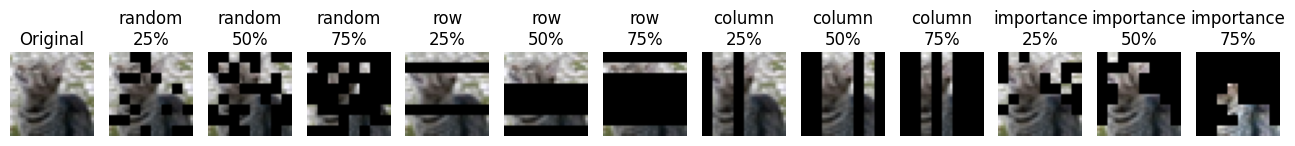

In [ ]:
strategies = ["random", "row", "column", "importance"]
mask_ratios = [0.25, 0.5, 0.75]
visualize_masking_strategies(image_batch, patch_layer, strategies, mask_ratios)

# 1ère approche : Entraînement à partir de zéro

## Définition du modéle

In [ ]:
# Transformer Block constitué de 2 principales couches
class TransformerBlock(layers.Layer):
    def __init__(self, projection_dim, num_heads, mlp_units, dropout=0.1):
      #projection_dim : la dimension des vecteurs utilisés dans les mécanismes d'attention.
      #num_heads : nombre de têtes dans le mécanisme MultiHeadAttention.
      #mlp_units : une liste d'unités dans les couches du MLP.
      #dropout : taux de régularisation, pour éviter le surapprentissage.


        super().__init__()
        #Multi-head attention

        #Normalisation de couche:  permet de normaliser les activations à chaque étape d'entraînement pour accélérer la convergence et stabiliser l'apprentissage.
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        #Mécanisme d'Attention Multi-tête: signifie que plusieurs "têtes" (ou "couches d'attention")
        #sont utilisées pour permettre au modèle de capturer différents aspects des relations entre les tokens
        self.attn = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=dropout
        )

        #Multi layer perceptron

        #Normalisation de couche:
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        #MLP
        self.mlp = keras.Sequential([
            layers.Dense(units, activation=tf.nn.gelu)
            for units in mlp_units #units définit le nombre de neurones dans chaque couche du MLP.
        ] + [layers.Dropout(dropout)])

    def call(self, inputs):
        # Aplliquer multi-headattention et ajouter le résidu
        x = self.norm1(inputs)
        x = self.attn(x, x)
        x = layers.Add()([inputs, x])

        # Appliquer MLP et Ajouter le Résidu
        y = self.norm2(x)
        y = self.mlp(y)
        return layers.Add()([x, y])

===> Un bloc Transformer constitué de deux principales sous-couches :
* L'attention multi-têtes (MultiHeadAttention): Le mécanisme d'attention est une technique clé des modèles Transformer. Il permet au modèle de se concentrer de manière dynamique sur différentes parties d'une entrée en fonction de leur pertinence pour la tâche à accomplir.
* Un perceptron multicouche (MLP): est un réseau de neurones classique, aussi appelé réseau entièrement connecté. Chaque couche d'un MLP contient des neurones connectés à tous les neurones de la couche suivante. L'idée est de transformer l'information en passant par plusieurs couches, ce qui permet de mieux comprendre des relations complexes.

Ce bloc est une implémentation de base d'un transformateur utilisé dans des modèles comme BERT, GPT, etc. Il applique une attention auto-référentielle, suivie d'un MLP pour générer des représentations contextualisées des entrées.

Arguments:
* projection_dim (int): La dimension des projections des clés et des valeurs dans l'attention multi-têtes.
* num_heads (int): Le nombre de têtes dans le mécanisme d'attention multi-têtes.
* mlp_units (list): Une liste d'entiers représentant les tailles des couches du MLP (perceptron multicouche).
* dropout (float, optional): Le taux de drop-out à appliquer, par défaut 0.1.

In [ ]:
#Implémentation d'un Vision Transformer (ViT) personnalisé
#pipeline
#Input image → découpée en patchs
#Patch Encoder → embeddings + masquage
#Ajout de mask tokens et embeddings positionnels
#Transformer Blocks → traitement global
#Decoder → reconstruction des patchs
#Output → patchs reconstruits + indices masqués




class ViTModel(keras.Model):
    def __init__(self, patch_size=PATCH_SIZE, projection_dim=PROJECTION_DIM,
                 transformer_layers=TRANSFORMER_LAYERS, num_heads=NUM_HEADS,
                 mlp_units=MLP_UNITS, masking_strategy="random", masking_ratio=MASK_RATIO):
        super().__init__()

        #Découpe l’image d’entrée en patchs
        self.patch_layer = Patches(patch_size)

        #projette chaque patch dans un espace de dimension projection_dim et applique le masquage
        self.patch_encoder = PatchEncoder(
            NUM_PATCHES, projection_dim,
            masking_strategy=masking_strategy,
            masking_ratio=masking_ratio
        )

        #Liste de couches Transformer qui traitent les représentations de patchs encodés.
        self.transformer_blocks = [
            TransformerBlock(projection_dim, num_heads, mlp_units)
            for _ in range(transformer_layers)
        ]

        #Transforme les sorties du Transformer pour reconstruire les patchs originaux.
        self.decoder_projection = layers.Dense(patch_size * patch_size * 3)

        #Vecteur appris représentant un patch masqué, injecté dans le modèle à la place des vrais embeddings de patchs masqués.
        self.mask_token = tf.Variable(
            tf.random.normal([1, 1, projection_dim]),
            trainable=True
        )

    def call(self, images):#Propagation avant #Prend un batch d’images et retourne une reconstruction des patchs masqués ainsi que leurs indices.

        # Création des patchs
        patches = self.patch_layer(images)
        batch_size = tf.shape(patches)[0]

        # Encodage et masquage des patchs (patchencoder)
        (unmasked_embeddings, masked_embeddings,
        unmasked_positions, mask_indices, unmask_indices) = self.patch_encoder(patches)

        # Création des tokens masqués
        mask_tokens = tf.tile(self.mask_token, [batch_size, NUM_MASK, 1])

        # Combine unmasked embeddings with mask tokens
        combined_embeddings = tf.concat([unmasked_embeddings, mask_tokens], axis=1)

        # Préparation des indices de mise à jour
        #On initialise un tenseur avec des zéros, puis on remplit les positions des patchs visibles avec leurs vrais embeddings, et les positions masquées avec mask_token.
        positions = tf.range(NUM_PATCHES)
        positions = tf.expand_dims(positions, 0)
        positions = tf.tile(positions, [batch_size, 1])
        #Ajout des embeddings positionnels
        pos_embeddings = self.patch_encoder.position_embedding(positions)

        # Create indices for scatter update
        batch_range = tf.range(batch_size)
        batch_range = tf.expand_dims(batch_range, -1)  # [batch_size, 1]

        # Create full indices for unmasked patches
        unmask_indices_expanded = tf.expand_dims(unmask_indices, -1)  # [batch_size, num_unmask, 1]
        batch_indices_unmask = tf.tile(batch_range, [1, tf.shape(unmask_indices)[1]])  # [batch_size, num_unmask]
        batch_indices_unmask = tf.expand_dims(batch_indices_unmask, -1)  # [batch_size, num_unmask, 1]
        full_indices_unmask = tf.concat([batch_indices_unmask, unmask_indices_expanded], axis=-1)  # [batch_size, num_unmask, 2]

        # Create full indices for masked patches
        mask_indices_expanded = tf.expand_dims(mask_indices, -1)  # [batch_size, num_mask, 1]
        batch_indices_mask = tf.tile(batch_range, [1, tf.shape(mask_indices)[1]])  # [batch_size, num_mask]
        batch_indices_mask = tf.expand_dims(batch_indices_mask, -1)  # [batch_size, num_mask, 1]
        full_indices_mask = tf.concat([batch_indices_mask, mask_indices_expanded], axis=-1)  # [batch_size, num_mask, 2]

        # Initialize transformer input
        transformer_input = tf.zeros([batch_size, NUM_PATCHES, PROJECTION_DIM])

        # Update with unmasked embeddings
        transformer_input = tf.tensor_scatter_nd_update(
            transformer_input,
            full_indices_unmask,
            unmasked_embeddings
        )

        # Update with mask tokens
        transformer_input = tf.tensor_scatter_nd_update(
            transformer_input,
            full_indices_mask,
            mask_tokens
        )

        # Add positional embeddings
        transformer_input += pos_embeddings

        #Passage dans les blocs Transformer
        for transformer_block in self.transformer_blocks:
            transformer_input = transformer_block(transformer_input)

        #Projection pour décodage
        decoded_patches = self.decoder_projection(transformer_input)

        # Reshape to image format
        decoded_patches = tf.reshape(
          decoded_patches,
          [batch_size, NUM_PATCHES, PATCH_SIZE * PATCH_SIZE * 3]
          )

        return decoded_patches, mask_indices
        #decoded_patches : patchs reconstruits (incluant les masqués).
        #mask_indices : permet de comparer les patchs reconstruits avec les originaux et calculer la perte de reconstruction.

===>
La classe ViTModel définit une version du Vision Transformer (ViT) adaptée pour des tâches de reconstruction d'images avec masquage de patches.
Elle prend des images en entrée, découpe l'image en petits patches, encode ces patches avec des stratégies de masquage, passe les représentations à travers plusieurs couches de transformeur, puis tente de reconstruire les patches masqués.

=> __init__(...)
Cette méthode initialise les différentes couches du modèle.

* self.patch_layer : Instance de la classe Patches pour découper les images en patches.

* self.patch_encoder : Instance de la classe PatchEncoder pour encoder les patches avec masquage.

* self.transformer_blocks : Liste de plusieurs blocs TransformerBlock appliqués en séquence.

* self.decoder_projection : Couche Dense pour projeter les embeddings des patches transformés vers l'espace original des pixels.

* self.mask_token : Variable entraînable représentant un token spécial pour remplacer les patches masqués.

=> call(images)
Cette méthode définit ce qui se passe quand le modèle est appelé sur des images.

* Création des patches : L'image est divisée en un ensemble de petits patches carrés.

* Encodage des patches :On applique PatchEncoder :

 - Les patches non masqués sont projetés dans l'espace des embeddings.

 - Les indices des patches masqués et non masqués sont extraits.

* Ajout des Mask Tokens :
 - Un token spécial (mask_token) est utilisé pour remplacer les patches masqués.

 - Les embeddings des patches non masqués et les mask tokens sont concaténés.

* Ajout d'Embeddings de Position :

 - Chaque patch reçoit une information sur sa position d'origine dans l'image.

* Passage par les blocs Transformer :  Les embeddings combinés passent à travers plusieurs couches Transformer pour modéliser les dépendances entre les patches.

* Décodage pour la Reconstruction : La sortie finale est projetée pour reconstruire les pixels des patches originaux à l'aide de decoder_projection.

In [ ]:
#calcule la perte de reconstruction (MSE) entre les patchs d’image d’origine et les patchs reconstruits par le modèle, mais uniquement sur les patchs masqués.
def reconstruction_loss(original, reconstructed, mask_indices):
    # original: [batch_size, height, width, channels]
    # reconstructed: [batch_size, num_patches, patch_height, patch_width, channels]
    # mask_indices: [batch_size, num_masked_patches]

    # On divise l’image d’origine en patchs avec la même classe Patches utilisée dans le modèle ViT.
    original_patches = Patches(PATCH_SIZE)(original)  # [batch_size, num_patches, patch_h, patch_w, channels]

    #On récupère dynamiquement la taille du batch et le nombre de patchs masqués.
    batch_size = tf.shape(original_patches)[0]
    num_masked = tf.shape(mask_indices)[1]  # Dynamic number of masked patches

    # On crée des indices de batch dupliqués pour être alignés avec les indices des patchs masqués.
    batch_indices = tf.tile(
        tf.reshape(tf.range(batch_size), [1, -1]),  # [1, batch_size]
        [num_masked, 1]
    )  # [num_masked, batch_size]
    batch_indices = tf.transpose(batch_indices)  # [batch_size, num_masked]



    # On combine les indices de batch et les indices des patchs masqués pour former des indices 2D utilisables avec tf.gather_nd
    full_indices = tf.stack([batch_indices, mask_indices], axis=-1)  # [batch_size, num_masked, 2]

    # On extrait uniquement les patchs masqués à la fois pour l’image d’origine et pour la sortie reconstruite.
    original_masked = tf.gather_nd(original_patches, full_indices)      # [batch_size, num_masked, patch_h, patch_w, channels]
    reconstructed_masked = tf.gather_nd(reconstructed, full_indices)    # [batch_size, num_masked, patch_h, patch_w, channels]

    # On aplatit les patchs pour pouvoir calculer la MSE : chaque patch devient un vecteur.
    original_masked_flat = tf.reshape(original_masked, [batch_size, num_masked, -1])      # [batch_size, num_masked, patch_dim]
    reconstructed_masked_flat = tf.reshape(reconstructed_masked, [batch_size, num_masked, -1])  # [batch_size, num_masked, patch_dim]

    # On calcule la moyenne des carrés des erreurs entre les vecteurs originaux et reconstruits.
    loss = tf.reduce_mean(tf.square(original_masked_flat - reconstructed_masked_flat))
    return loss


===> **reconstruction_loss** est une fonction qui calcule la perte de reconstruction (loss) entre des images originales et leurs reconstructions,  mais uniquement sur les parties masquées.

Arguments :

* original (tf.Tensor) :  Tenseur de forme [batch_size, height, width, channels] représentant les images originales complètes.
    
* reconstructed (tf.Tensor) :  Tenseur de forme [batch_size, num_patches, patch_height, patch_width, channels] représentant les patchs reconstruits par le modèle.
    
* mask_indices (tf.Tensor) :  Tenseur de forme [batch_size, num_masked_patches] contenant, pour chaque image du batch, les indices des patchs qui ont été masqués et donc reconstruits.

Retour : loss (tf.Tensor) :
        Un scalaire représentant l'erreur quadratique moyenne (MSE) entre les patchs originaux masqués
        et leurs reconstructions correspondantes.

In [ ]:
# Initialize model
model = ViTModel(masking_strategy="random", masking_ratio=MASK_RATIO)#mask_ratio = 0.5

===> Initialisation du modèle ViTModel.

Lors de l'entraînement, une partie des patchs (mask_ratio%) de l'image est masquée aléatoirement suivant la stratégie spécifiée, et le modèle apprend à reconstruire ces patchs.

## Entrainement

In [ ]:
# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

===> Initialisation de l'optimiseur Adam.

Adam (Adaptive Moment Estimation) est un optimiseur basé sur la descente de gradient.

In [ ]:
# Metrics
train_loss = keras.metrics.Mean(name="train_loss")
val_loss = keras.metrics.Mean(name="val_loss")

===>Initialisation des métriques de suivi de la perte (loss)

* train_loss : Utilisé pour calculer et stocker la perte moyenne sur les lots d'entraînement.
* val_loss : Utilisé pour calculer et stocker la perte moyenne sur les lots de validation.

NB:  keras.metrics.Mean accumule les valeurs fournies et calcule la moyenne automatiquement.


In [ ]:
#Cette fonction représente une étape d'entraînement : elle calcule la perte, effectue la rétropropagation et met à jour les poids du modèle.
@tf.function #annotation pour que TensorFlow optimise la fct et la compile en graphe statique pour accélérer son exécution.
def train_step(images):

  #Utilisation de tf.GradientTape pour la rétropropagation
  #tf.GradientTape est utilisé pour suivre les opérations effectuées sur les variables du modèle afin de pouvoir calculer les gradients pendant la rétropropagation.
    with tf.GradientTape() as tape:
        reconstructed_patches, mask_indices = model(images) #Le batch d'images est passé à travers le modèle qui renvoie les patchs reconstruits et les indices des patchs masqués.
        loss = reconstruction_loss(images, reconstructed_patches, mask_indices)#calcul de la perte de reconstruction

    #calculer les gradients de la perte par rapport aux variables entraînables du modèle
    gradients = tape.gradient(loss, model.trainable_variables)
    #Application des gradients avec l'optimiseur
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #Enregistrement de la perte d'entraînement
    train_loss(loss)

===>Cette fonction effectue une étape d'entraînement complète :
* Elle passe les images dans le modèle pour obtenir les patches reconstruits et les indices masqués.
* Elle calcule la perte entre les patches originaux et les patches reconstruits.
* Elle calcule les gradients de la perte par rapport aux poids entraînables du modèle.
* Elle met à jour les poids du modèle à l'aide de l'optimiseur.
* Elle met à jour la métrique de perte d'entraînement.

Cette fonction est appelée à chaque batch d'entraînement.

----------------------------------

=> tf.GradientTape() : Utilisé pour enregistrer les opérations afin de calculer automatiquement les gradients.

=>tape.gradient : Calcule les gradients de la perte par rapport aux variables entraînables.

=> optimizer.apply_gradients : Applique les gradients pour mettre à jour les paramètres du modèle.

=>train_loss(loss) : Met à jour la métrique 'train_loss' avec la perte actuelle.

In [ ]:
#fonction pour calculer la perte sur l'ensemble de validation pendant l'entraînement d'un modèle TensorFlow.
@tf.function
def val_step(images):
    reconstructed_patches, mask_indices = model(images)#Cette ligne applique le modèle à un lot d'images (entrées).
    loss = reconstruction_loss(images, reconstructed_patches, mask_indices) #calcule la perte de reconstruction entre les images originales et les patchs reconstruits générés par le modèle.
    val_loss(loss)#    #Enregistrement de la perte d'entraînement

===> Cette fonction effectue une étape de validation :
* Elle passe les images dans le modèle pour obtenir les patches reconstruits et les indices masqués.
* Elle calcule la perte entre les patches originaux et les patches reconstruits.
* Elle met à jour la métrique de perte de validation.


 --------------------------------------
=> model(images) : Reconstruit les patches à partir des images d'entrée.

=>reconstruction_loss : Calcule la perte entre les patches originaux et reconstruits sur les zones masquées.

=> val_loss(loss) : Met à jour la métrique 'val_loss' avec la perte actuelle.


In [ ]:
#fonction d'entrainement du modéle (li bech tlem li hkina aalih lkol)
def train_model(epochs=EPOCHS):
    for epoch in range(epochs):
        # Réinitialisation des métriques pour chaque epoch
        train_loss.reset_state()
        val_loss.reset_state()

        # Boucle d'entrainement
        for images in train_ds: #train set
            train_step(images) #effectuer etape d'entrainnement

        # Boucle de validation
        for images in val_ds:#validation set
            val_step(images) #effectuer etape de validation

        print(
            f"Epoch {epoch + 1}, "
            f"Train Loss: {train_loss.result():.4f}, "
            f"Val Loss: {val_loss.result():.4f}"
        )

===>Fonction d'entraînement du modèle.

 Cette fonction entraîne le modèle sur plusieurs époques (epochs) et évalue sa performance sur un jeu de validation à la fin de chaque époque.


In [ ]:
# Start training
train_model()

Epoch 1, Train Loss: 3622.2300, Val Loss: 2708.4751
Epoch 2, Train Loss: 2690.8704, Val Loss: 2588.8960
Epoch 3, Train Loss: 2606.5364, Val Loss: 2545.4727
Epoch 4, Train Loss: 2539.6506, Val Loss: 2483.6909
Epoch 5, Train Loss: 2467.3491, Val Loss: 2407.0417
Epoch 6, Train Loss: 2372.1067, Val Loss: 2289.0938
Epoch 7, Train Loss: 2270.7449, Val Loss: 2211.9351
Epoch 8, Train Loss: 2182.6755, Val Loss: 2127.2808
Epoch 9, Train Loss: 2134.8164, Val Loss: 2059.0134
Epoch 10, Train Loss: 2078.1370, Val Loss: 1991.4200
Epoch 11, Train Loss: 2050.4746, Val Loss: 1995.5040
Epoch 12, Train Loss: 2019.6246, Val Loss: 1992.1996
Epoch 13, Train Loss: 1984.1938, Val Loss: 1994.8687
Epoch 14, Train Loss: 1957.3064, Val Loss: 1921.0978
Epoch 15, Train Loss: 1920.5260, Val Loss: 1900.8242
Epoch 16, Train Loss: 1889.5054, Val Loss: 1836.2150
Epoch 17, Train Loss: 1834.7058, Val Loss: 1762.3386
Epoch 18, Train Loss: 1798.7581, Val Loss: 1748.7778
Epoch 19, Train Loss: 1760.1810, Val Loss: 1704.4944
Ep

## Evaluation

In [ ]:
#fonction utilisée pour afficher les images originales et reconstruites
def evaluate_model(dataset, num_samples=10):
    # Obtenir un lot d'exemples depuis le dataset
    sample_batch = next(iter(dataset))  # Already batched
    sample_images = sample_batch[:num_samples]  # Take first N images

    # Obtenir les reconstructions et les indices des patches masqués
    reconstructed_patches, mask_indices = model(sample_images)

    # Boucle pour afficher les images originales et reconstruites
    for i in range(num_samples):
        plt.figure(figsize=(8, 4))

        # ----- ORIGINAL IMAGE -----
        plt.subplot(1, 2, 1)
        plt.imshow(keras.utils.array_to_img(sample_images[i]))
        plt.title("Original")
        plt.axis("off")

        # ----- RECONSTRUCTED IMAGE -----

        #Obtenir et préparer les patches originaux et prédits

        # Get predicted patches for all positions
        all_predicted_patches = reconstructed_patches[i]  # shape: (num_patches, patch_dim)
        # Get original patches
        orig_patches = model.patch_layer(sample_images[i:i+1])[0]  # shape: (num_patches, patch_dim)
        # Get the indices of the masked patches
        mask_idx = mask_indices[i]  # shape: (num_masked_patches,)

        # Sélectionner les patches masqués prédits
        masked_pred_patches = tf.gather(all_predicted_patches, mask_idx)

        # Mettre à jour les patches originaux avec les patches masqués
        combined_patches = tf.tensor_scatter_nd_update(
            orig_patches,
            indices=tf.expand_dims(mask_idx, axis=1),  # shape: (num_masked, 1)
            updates=masked_pred_patches
        )

        #Reconstruire l'image à partir des patches combinés
        rec_image = model.patch_layer.reconstruct_from_patch(combined_patches)

        # Show the reconstructed image
        plt.subplot(1, 2, 2)
        plt.imshow(keras.utils.array_to_img(rec_image))
        plt.title("Reconstructed")
        plt.axis("off")

        plt.show()

===> Cette fonction évalue la performance du modèle en générant des reconstructions d'images à partir d'un jeu d'échantillons fourni.

Pour chaque image, elle affiche l'image originale et sa reconstruction après que les patches masqués ont été prédits et réinsérés.

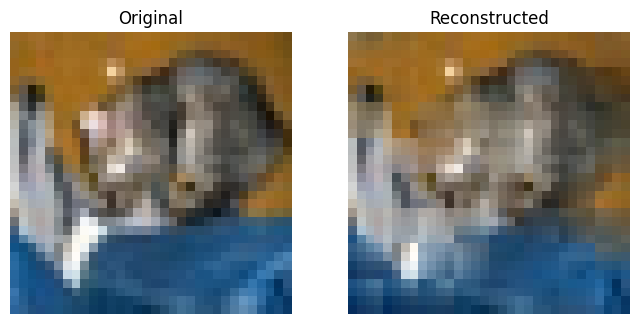

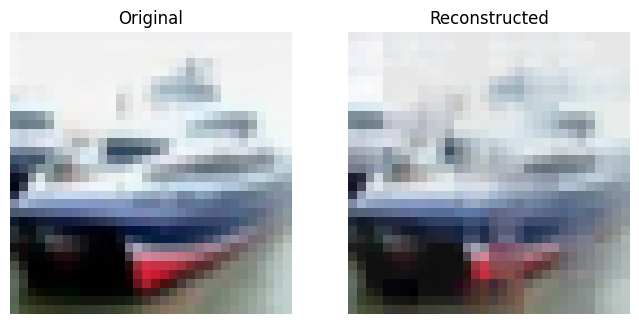

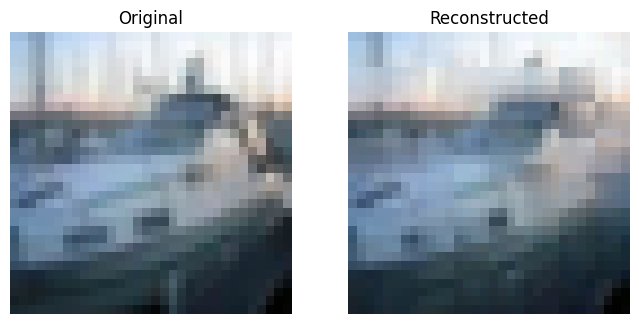

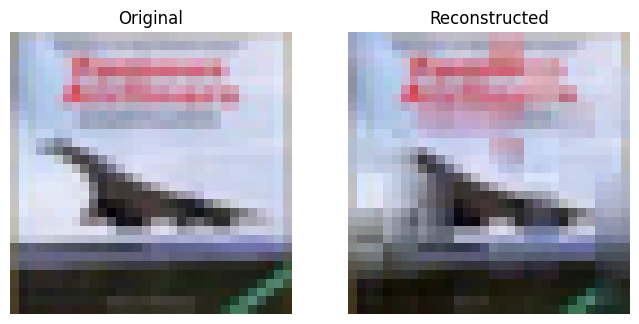

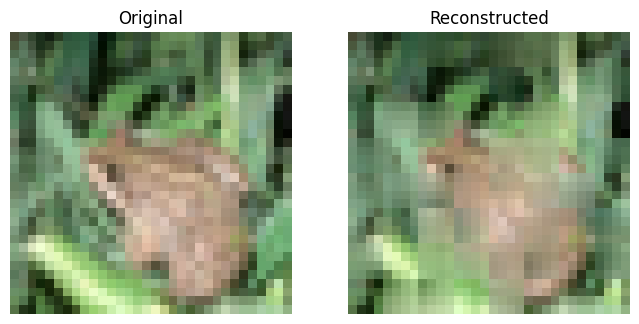

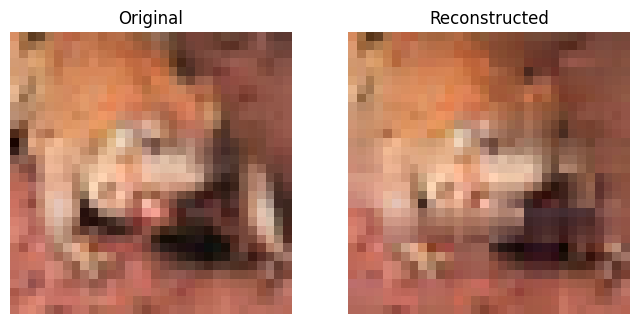

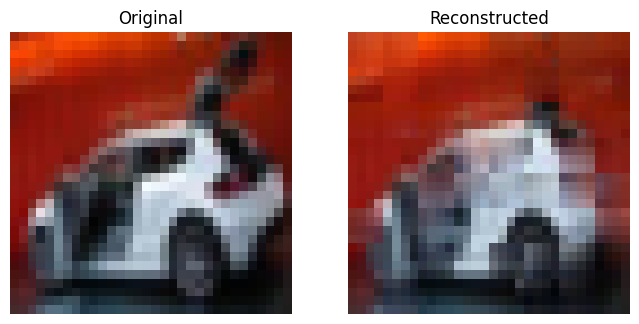

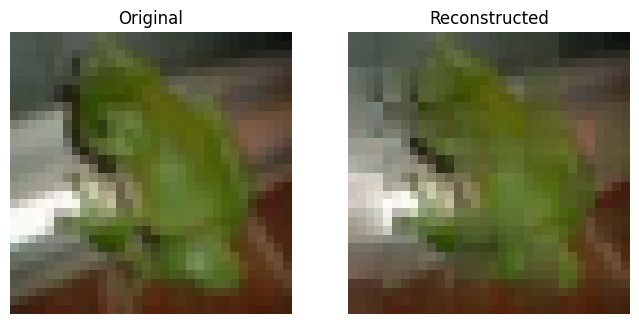

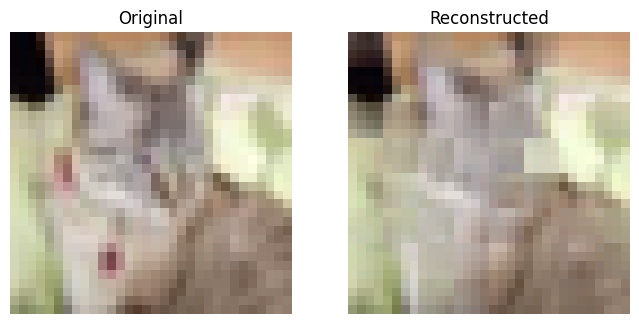

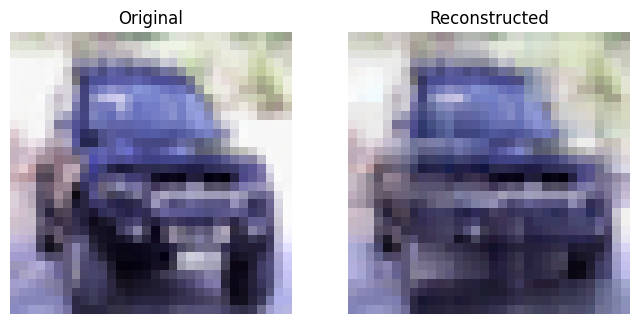

In [ ]:
# Evaluate on test set
evaluate_model(test_ds)

In [ ]:
#évaluer la qualité de la reconstruction des images générées par le modèle en calculant deux métriques populaires : le SSIM (Structural Similarity Index)
def evaluate_all_metrics(dataset, dataset_name="Dataset"):
    """Evaluate reconstruction quality metrics on a given dataset."""
    ssim_values = []
    psnr_values = []

    for images in dataset:
        # Convert images to float32 and scale to [0, 255] range
        images = tf.cast(images, tf.float32) * 255.0
        #Obtenir les reconstructions et les indices des patches masqués :
        reconstructed_patches, mask_indices = model(images)

        for i in range(len(images)):
            # Reconstruct image
            all_predicted_patches = reconstructed_patches[i]
            orig_patches = model.patch_layer(images[i:i+1])[0]
            mask_idx = mask_indices[i]
            masked_pred_patches = tf.gather(all_predicted_patches, mask_idx)
            combined_patches = tf.tensor_scatter_nd_update(
                orig_patches,
                indices=tf.expand_dims(mask_idx, axis=1),
                updates=masked_pred_patches
            )
            #Reconstruire l'image finale à partir des patches combinés :
            rec_image = model.patch_layer.reconstruct_from_patch(combined_patches)

            # Ensure both images are in [0, 255] range and uint8
            orig_image = tf.cast(tf.clip_by_value(images[i], 0, 255), tf.uint8)
            rec_image = tf.cast(tf.clip_by_value(rec_image, 0, 255), tf.uint8)

            # Calculate metrics
            #L'idée de SSIM est de mesurer la similarité de structure entre les deux images, plutôt qu'une différence pixel à pixel comme le fait par exemple le PSNR.

            ssim_value = ssim(
                orig_image.numpy(),
                rec_image.numpy(),
                multichannel=True,
                data_range=255.0,
                channel_axis=-1
            )

            psnr_value = tf.image.psnr(
                tf.expand_dims(orig_image, 0),
                tf.expand_dims(rec_image, 0),
                max_val=255.0
            ).numpy()[0]

            ssim_values.append(ssim_value)
            psnr_values.append(psnr_value)

    # Calculate average metrics
    avg_ssim = np.mean(ssim_values)
    avg_psnr = np.mean(psnr_values)
    std_ssim = np.std(ssim_values)
    std_psnr = np.std(psnr_values)

    print(f"\nEvaluation on {dataset_name}:")
    print(f"Average SSIM: {avg_ssim:.4f} ± {std_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.4f} ± {std_psnr:.4f}")
    print(f"Number of samples: {len(ssim_values)}")

    return {
        'ssim': avg_ssim,
        'psnr': avg_psnr,
        'ssim_std': std_ssim,
        'psnr_std': std_psnr,
        'num_samples': len(ssim_values)
    }

===> Cette fonction évalue les métriques de qualité de reconstruction, à savoir le SSIM (Structural Similarity Index) et le PSNR (Peak Signal-to-Noise Ratio), sur un jeu de données donné. Elle compare les images originales avec leurs reconstructions générées par le modèle.

**Étapes de la fonction :**

=> Initialisation des listes pour SSIM et PSNR : Les valeurs calculées pour chaque image seront stockées dans ssim_values et psnr_values.

=> Conversion et prétraitement des images : Les images sont converties en type float32 et mises à l'échelle dans la plage [0, 255] pour la comparaison.

=> Reconstructions et calcul des métriques :
Pour chaque image, le modèle génère les patches prédits et les indices des patches masqués. Ces patches sont ensuite réintégrés dans l'image originale, et l'image reconstruite est obtenue.
Le SSIM et le PSNR sont ensuite calculés entre l'image originale et l'image reconstruite.

=> Calcul des moyennes et des écarts-types :
Les moyennes et les écarts-types des valeurs SSIM et PSNR sont calculés pour toutes les images du jeu de données.

=>Affichage des résultats :
Les résultats de l'évaluation (moyenne et écart-type de SSIM et PSNR) sont affichés dans la console.

In [ ]:
# Evaluate on both validation and test sets
val_metrics = evaluate_all_metrics(val_ds, "Validation Set")
test_metrics = evaluate_all_metrics(test_ds, "Test Set")

/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)



Evaluation on Validation Set:
Average SSIM: 0.8278 ± 0.0887
Average PSNR: inf ± nan
Number of samples: 10000

Evaluation on Test Set:
Average SSIM: 0.8299 ± 0.0866
Average PSNR: inf ± nan
Number of samples: 10000


The result Average PSNR: inf ± nan indicates that there was an issue with the calculation of the Peak Signal-to-Noise Ratio (PSNR).

## Comparaison avec auto-encodeur

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, losses
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
# 1. Charger les données
(x_train, _), (x_test, _) = cifar10.load_data()

print(x_train.shape)  # (50000, 32, 32, 3)
print(x_test.shape)   # (10000, 32, 32, 3)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
latent_dim = 128

class ConvAutoencoder(Model):
    def __init__(self, latent_dim):
        super(ConvAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),
            layers.Flatten(),
            layers.Dense(latent_dim, activation='relu'),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(4 * 4 * 128, activation='relu'),
            layers.Reshape((4, 4, 128)),
            layers.Conv2DTranspose(128, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(3, (3, 3), activation=None, padding='same')  # activation None
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = ConvAutoencoder(latent_dim)

* Dimensions : CIFAR-10 a des images avec 3 canaux (pas 1 comme Fashion MNIST), donc la forme est (32, 32, 3) au lieu de (28, 28, 1).

* Architecture : Le modèle dense/fully connected fonctionne, mais pour des images plus complexes (CIFAR-10 a plus de détails que Fashion MNIST), une architecture convolutionnelle (cad Utilise des filtres (kernels) qui balayent l’image pour détecter des motifs locaux.) est généralement plus efficace pour la reconstruction.

* Latent space & profondeur : Il faut un latent space un peu plus riche (par ex. 128 ou 256) et des couches convolutives pour mieux capturer les motifs des images couleur.



In [ ]:
# 3. Compilation & entraînement
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 212s 533ms/step - loss: 4218.6694 - val_loss: 1251.3503
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 271s 557ms/step - loss: 1157.8915 - val_loss: 927.1393
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 255s 540ms/step - loss: 792.6630 - val_loss: 692.2261
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 266s 550ms/step - loss: 684.8095 - val_loss: 708.6430
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 261s 547ms/step - loss: 639.2877 - val_loss: 570.7383
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 212s 541ms/step - loss: 572.1967 - val_loss: 552.6711
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 264s 547ms/step - loss: 545.8040 - val_loss: 516.0685
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 263s 548ms/step - loss: 517.8531 - val_loss: 523.0390
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 286s 611ms/step - loss: 504.1609 - val_loss: 487.4729
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 251s 583ms/step - loss: 475.0766 - val_loss: 484.0128
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 246s 542ms/step

In [ ]:
# 4. Visualisation des résultats
decoded_imgs = autoencoder(x_test).numpy()

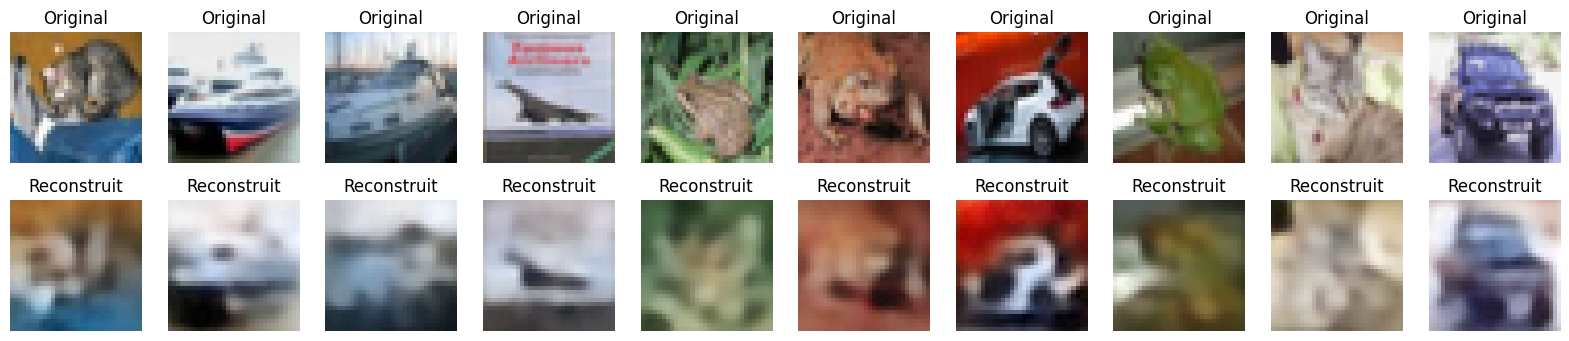

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].astype('uint8'))  # on garde tel quel
    plt.title("Original")
    ax.axis('off')

    # Reconstruit
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(np.clip(decoded_imgs[i], 0, 255).astype('uint8'))  # clip si besoin
    plt.title("Reconstruit")
    ax.axis('off')
plt.show()

In [ ]:
ssim_scores = []
for i in range(len(x_test)):
    # Important: les deux images doivent être en float32 pour tf.image.ssim
    img1 = tf.convert_to_tensor(x_test[i], dtype=tf.float32)
    img2 = tf.convert_to_tensor(decoded_imgs[i], dtype=tf.float32)

    score = tf.image.ssim(img1, img2, max_val=255.0).numpy()
    ssim_scores.append(score)

print("SSIM moyen :", np.mean(ssim_scores))

SSIM moyen : 0.7164769


# 2éme approche: Fine tune a pretrained model!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from transformers import ViTFeatureExtractor, ViTMAEForPreTraining

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("facebook/vit-mae-base", do_rescale=False)  # Disable rescaling
mae_model = ViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base").to(device)


In [ ]:
# 2. Freeze the encoder (only train the decoder)
for param in mae_model.vit.parameters():
    param.requires_grad = False

print(" Encoder frozen — training decoder only!")

✅ Encoder frozen — training decoder only!


In [ ]:
# 3. Prepare CIFAR-10 Data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

In [ ]:
# 4. Define optimizer (only decoder params)
optimizer = optim.AdamW(mae_model.decoder.parameters(), lr=1e-4)

# 5. Loss function (L2 loss for reconstruction)
loss_fn = nn.MSELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mae_model = mae_model.to(device)

# 6. Training loop
epochs = 10  # Quick finetuning

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    mae_model.train()

    for images, _ in trainloader:
        images = images.to(device)

        # Preprocess for ViT-MAE
        inputs = feature_extractor(images=list(images), return_tensors="pt").to(device)

        # Forward
        outputs = mae_model(**inputs)

        # Unpatchify outputs (reconstructed images)
        reconstructed = mae_model.unpatchify(outputs.logits)

        # Compute loss
        loss = loss_fn(reconstructed, inputs.pixel_values)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.6f}")

print(" Finetuning complete!")